<!-- <img src="![one](https://github.com/Pushkar1853/kaggle-resources/blob/main/%231%20Image%20segmentation/BFcU2vjUXh.png)" width="100"> -->
 <div>
 <img src="https://github.com/Pushkar1853/kaggle-resources/blob/main/%231%20Image%20segmentation/BFcU2vjUXh.png?raw=true" width="170px">
     </div>

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#C3976A;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="padding: 10px;
              color:white; ">
Image Segmentation Series <br>
    (Using UNet and implementation in Pytorch)
</h1>
</div>

![image1](https://scale.com/_next/image?url=https%3A%2F%2Fcdn.builder.io%2Fapi%2Fv1%2Fimage%2Fassets%252Fe0438815ba51486bbb6a202747122d4b%252F194273f74cae4d4ba4acf239253bca2b&w=992&q=100)

# Story

<h3>Hi everyone!</h3><br>
I have recently started working on Image segmentation. But, I only found part of the notebook on kaggle where you could read and understand the work. I decided to make a series of notebooks on different and challenging datasets.<br> If you find any improvements, I would love to discuss them. 

# What is image segmentation?

As the term suggests, this is dividing an image into multiple segments. In this process, every pixel in the image is associated with an object type. There are two significant types of image segmentation: semantic and instance.<br>
In semantic segmentation, all objects of the same type are marked using one class label, while in instance segmentation, similar objects get their separate labels.

<div>
<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/semantic_vs_instance.png?ssl=1" width="900px"align="center">
    </div>
<!-- ![int vs sem](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/semantic_vs_instance.png?ssl=1)<br> -->
Anurag Arnab, Shuai Zheng et. al 2018 “Conditional Random Fields Meet Deep Neural Networks for Semantic Segmentation” |

## Image segmentation architectures

<em> The basic architecture in image segmentation consists of an encoder and a decoder. </em>

<div>
<img src="https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Image-segmentation-architectures.png?ssl=1" width="900px"align="center">
    </div><br>
<!-- [img4](https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Image-segmentation-architectures.png?ssl=1)<br> -->
Vijay Badrinarayanan et. al 2017 “SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation”

The encoder extracts features from the image through filters. The decoder generates the final output, usually a segmentation mask containing the object's outline. Most of the architectures have this architecture or a variant of it.

In this notebook, I'll be primarily focusing on **UNet**.
<br>

<br>
    <b>U-Net</b>
    is a <em>convolutional neural network</em> developed initially for segmenting biomedical images. When visualized, its architecture looks like the letter U and hence the name U-Net. Its architecture is made up of two parts, the left part – the contracting path and the right part – the expansive path. The purpose of the contracting path is to capture context, while the role of the expansive path is to aid in precise localization.

<div>
<img src="https://github.com/Pushkar1853/kaggle-resources/blob/main/%231%20Image%20segmentation/Unet-arch.png?raw=true" width="800px"align="center">
    </div><br>
    The contracting path is made up of two three-by-three convolutions. The convolutions are followed by a rectified linear unit and a two-by-two max-pooling computation for downsampling.

## About the dataset
**Source** : https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx
<br>


The data majorly looks like: 
<div>
<img src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/overview_tiles.jpg?width=398.4830805134189&height=500" width="500px"align="center">
    </div><br>

And we have to make use of this
<div>
<img src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/examples_top_dsm_gts.png?width=500&height=196.7930029154519" width="600px">
    </div><br>
    Example patches of the semantic object classification contest with (a) true orthophoto, (b) DSM, and (c) ground truth

<h3>Now, Let's dive straight into the code</h3>

# Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
#from tqdm.notebook import tqdm
from tqdm import tqdm

# !pip install -q segmentation-models-pytorch
# !pip install -q torchsummary

# from torchsummary import summary
# import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH =r'C:\Users\c1203\Desktop\vaihingen\vaihingen(image)\img_dir\train\\'
MASK_PATH = r'C:\Users\c1203\Desktop\vaihingen\vaihingen(annotation)\ann_dir\train\\'

# Preprocessing

In [3]:
n_classes = 7

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            index_name = (filename.split('.')[0])
            index = index_name.strip("abcdefghijklmnopqrstuvwxyz")
            name.append(index)
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  344


In [4]:
df.head()

,id
0,11_0_0_512_512
1,11_0_1024_512_1536
2,11_0_1536_512_2048
3,11_0_2048_512_2560
4,11_0_2054_512_2566


In [5]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  262
Val Size     :  47
Test Size    :  35


Image Size (512, 512, 3)
Mask Size (512, 512)


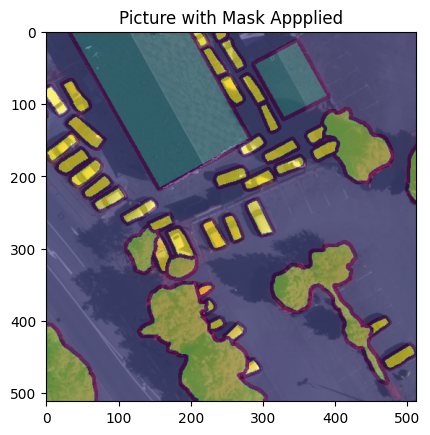

In [6]:
img = Image.open(IMAGE_PATH + 'area' + df['id'][10] + '.png')
mask = Image.open(MASK_PATH + 'area' +df['id'][10] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Define Dataset

In [7]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + 'area' + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + 'area' + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
print(len(train_set))
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)
print(len(val_set))

#dataloader
batch_size= 3
num_workers = 0

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(len(train_loader))
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
print(len(val_loader))

262
47
88
16


# Define Model

## Attempt 1

In [9]:
# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
#         self.bn1 = nn.BatchNorm2d(out_ch)
#         self.relu = nn.ReLU()
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
#         self.bn2 = nn.BatchNorm2d(out_ch)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)

#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         return x


# class Encoder(nn.Module):
#     def __init__(self, chs=(3, 64, 128, 256, 512, 1024)):
#         super().__init__()
#         self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
#         self.pool = nn.MaxPool2d(2)

#     def forward(self, x):
#         ftrs = []
#         for block in self.enc_blocks:
#             x = block(x)
#             ftrs.append(x)
#             x = self.pool(x)
#         return ftrs


# class Decoder(nn.Module):
#     def __init__(self, chs=(1024, 512, 256, 128, 64)):
#         super().__init__()
#         self.chs = chs
#         self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1],3,2,1,1) for i in range(len(chs) - 1)])
#         self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])

#     def forward(self, x, encoder_features):
#         for i in range(len(self.chs) - 1):
#             x = self.upconvs[i](x)
#             enc_ftrs = self.crop(encoder_features[i], x)
#             x = torch.cat([x, enc_ftrs], dim=1)
#             x = self.dec_blocks[i](x)
#         return x

#     def crop(self, enc_ftrs, x):
#         _, _, H, W = x.shape
#         enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
#         return enc_ftrs


# class UNet(nn.Module):
#     def __init__(self, enc_chs=(3, 64, 128, 256, 512, 1024), dec_chs=(1024, 512, 256, 128, 64), num_class=7,retain_dim=True):
#         super().__init__()
#         self.encoder = Encoder(enc_chs)
#         self.decoder = Decoder(dec_chs)
#         self.head = nn.Conv2d(dec_chs[-1], num_class, 1)
#         self.retain_dim = retain_dim
#         self.initialize()

#     def initialize(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x, out_sz=(512, 512)):
#         enc_ftrs = self.encoder(x)
#         out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
#         out = self.head(out)
#         out = F.softmax(out, dim=1)
#         if self.retain_dim:
#             out = F.interpolate(out, out_sz)
#         return out

## Attempt 2

In [ ]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.double_conv(x)
    
    
# class DownBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DownBlock, self).__init__()
#         self.double_conv = DoubleConv(in_channels, out_channels)
#         self.down_sample = nn.MaxPool2d(2)

#     def forward(self, x):
#         skip_out = self.double_conv(x)
#         down_out = self.down_sample(skip_out)
#         return (down_out, skip_out)

    
# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, up_sample_mode):
#         super(UpBlock, self).__init__()
#         if up_sample_mode == 'conv_transpose':
#             self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
#         elif up_sample_mode == 'bilinear':
#             self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         else:
#             raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
#         self.double_conv = DoubleConv(in_channels, out_channels)

#     def forward(self, down_input, skip_input):
#         x = self.up_sample(down_input)
#         x = torch.cat([x, skip_input], dim=1)
#         return self.double_conv(x)

    
# class UNet(nn.Module):
#     def __init__(self, out_classes=6, up_sample_mode='conv_transpose'):
#         super(UNet, self).__init__()
#         self.up_sample_mode = up_sample_mode
        
#         # Downsampling Path
        
#         self.down_conv1 = DownBlock(3, 64)
#         self.down_conv2 = DownBlock(64, 128)
#         self.down_conv3 = DownBlock(128, 256)
#         self.down_conv4 = DownBlock(256, 512)
        
#         # Bottleneck
        
#         self.double_conv = DoubleConv(512, 1024)
        
#         # Upsampling Path
        
#         self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
#         self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
#         self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
#         self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        
#         # Final Convolution
        
#         self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

#     def forward(self, x):
#         x, skip1_out = self.down_conv1(x)
#         x, skip2_out = self.down_conv2(x)
#         x, skip3_out = self.down_conv3(x)
#         x, skip4_out = self.down_conv4(x)
#         x = self.double_conv(x)
#         x = self.up_conv4(x, skip4_out)
#         x = self.up_conv3(x, skip3_out)
#         x = self.up_conv2(x, skip2_out)
#         x = self.up_conv1(x, skip1_out)
#         x = self.conv_last(x)
#         return x

## Attempt 3

In [10]:
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3,padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta= tensor_size - target_size
    delta = delta//2
    return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]

class UNet(nn.Module):
    def __init__(self, num_channels, num_classes,retain_dim=True):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(num_channels, out_c=64)
        self.down_conv_2 = double_conv(in_c=64, out_c=128)
        self.down_conv_3 = double_conv(in_c=128, out_c=256)
        self.down_conv_4 = double_conv(in_c=256, out_c=512)
        self.down_conv_5 = double_conv(in_c=512, out_c=1024)
    
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2,stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(
            in_channels=64,
            out_channels = num_classes, # Number of objects to segment
            kernel_size=1,

        )
        self.retain_dim = retain_dim

    def forward(self, image,out_size=(512, 512)):
        # batch size, channel, height, width
        # encoder part
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # decoder part
        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))

        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))

        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))

        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))

        x = self.out(x)
        if self.retain_dim:
            x = F.interpolate(x, out_size)
        # print(x.size())
        # x = torch.sigmoid(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
model = UNet(num_channels=3, num_classes=7)

In [12]:
model

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [13]:
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([3, 3, 512, 512]) torch.Size([3, 512, 512])


In [14]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([3, 7, 512, 512])


# Loss function definition

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=7):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

# Train and validate the model

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 250:
                    print('Loss not decrease for 200 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Accuracy:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Accuracy:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-4
epoch = 150 
weight_decay = 1e-6

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

100%|██████████| 16/16 [01:59<00:00,  7.47s/it]


Loss Decreasing.. inf >> 1.865 
Epoch:1/150.. Train Loss: 1.913.. Val Loss: 1.865.. Train mIoU:0.128.. Val mIoU: 0.139.. Train Accuracy:0.275.. Val Accuracy:0.356.. Time: 36.36m


 43%|████▎     | 38/88 [15:33<20:27, 24.56s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'Unet.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss'); 
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Model Prediction

In [ ]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path +'area' +self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + 'area' + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

# Images of Predictions

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [ ]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [ ]:
image3, mask3 = test_set[10]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

<h3>Courtesy and Sources:</h3>
Thank you for reading this notebook. I hope you found something useful. This notebook could not be possible without these resources. Make sure to check it out.

*  https://neptune.ai/blog/image-segmentation
* https://data-flair.training/blogs/image-segmentation-machine-learning/
* https://arxiv.org/abs/1511.00561
* https://ieeexplore.ieee.org/document/8254255
* https://arxiv.org/abs/1505.04597
* https://scale.com/blog/ml-image-segmentation

If you do find this notebook useful, please upvote. This will motivate me to add more examples to the series. Also comment which datasets you want.

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:140%;
           font-family:Verdana;
           letter-spacing:0.5px;">

<p style="padding: 10px;
              color:white;
          text-align: center;">  Please upvote 🙏
</p>
</div>